In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import requests
!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

# Load New York DataSet

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data['features']

[{'type': 'Feature',
  'id': 'nyu_2451_34572.1',
  'geometry': {'type': 'Point',
   'coordinates': [-73.84720052054902, 40.89470517661]},
  'geometry_name': 'geom',
  'properties': {'name': 'Wakefield',
   'stacked': 1,
   'annoline1': 'Wakefield',
   'annoline2': None,
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.84720052054902,
    40.89470517661,
    -73.84720052054902,
    40.89470517661]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.2',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82993910812398, 40.87429419303012]},
  'geometry_name': 'geom',
  'properties': {'name': 'Co-op City',
   'stacked': 2,
   'annoline1': 'Co-op',
   'annoline2': 'City',
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.82993910812398,
    40.87429419303012,
    -73.82993910812398,
    40.87429419303012]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.3',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82780644716412, 

# Load All Features into Pandas DataFrame

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
features=newyork_data['features']
df_newyork = pd.DataFrame(columns=column_names)
    
for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        
        df_newyork = df_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    

In [6]:
df_newyork.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
df_newyork.shape

(306, 4)

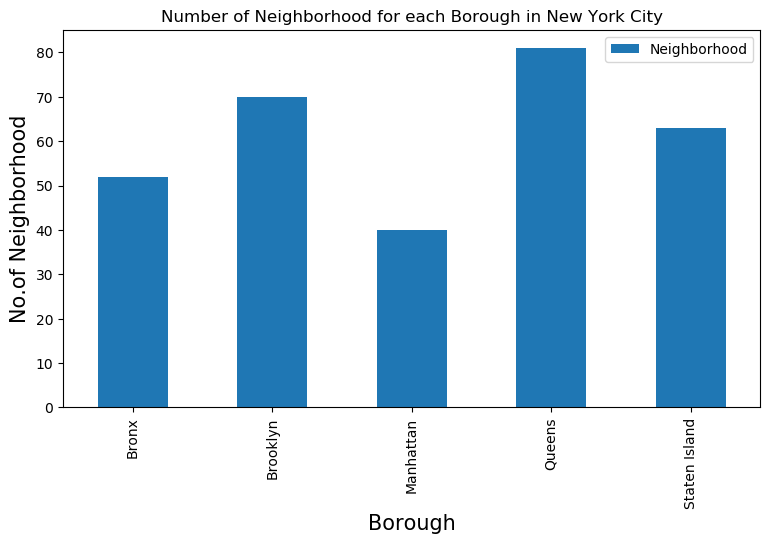

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_newyork.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [9]:
# create map of Toronto using latitude and longitude values
map_NewYork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_newyork['Latitude'], df_newyork['Longitude'], df_newyork['Borough'], df_newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NewYork)  
    
map_NewYork

# Loading NY DemoGraphics Data

In [10]:
from bs4 import BeautifulSoup # package for parsing HTML and XML documents
import csv
website_url = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(website_url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
#print(soup.prettify())

headers = [header.text for header in table.find_all('th')]

table_rows = table.find_all('tr')        
rows = []
for row in table_rows:
   td = row.find_all('td')
   row = [row.text for row in td]
   rows.append(row)

In [11]:
with open('Newyork_Population.csv', 'w') as f:
   writer = csv.writer(f)
   writer.writerow(headers)
   writer.writerows(row for row in rows if row)

In [12]:
df_NY_Population=pd.read_csv('Newyork_Population.csv')


In [13]:
df_NY_Population

,New York City's five boroughsvte,Jurisdiction,Population,Gross Domestic Product,Land area,Density,Borough,County,Estimate (2017)[12],billions(US$)[13],per capita(US$),square miles,squarekm,persons / sq. mi,persons /sq. km
0,The Bronx\n,\n Bronx\n,"1,471,160\n",28.787\n,"19,570\n",42.10\n,109.04\n,"34,653\n","13,231\n",NaN,NaN,NaN,NaN,NaN,NaN
1,Brooklyn\n,\n Kings\n,"2,648,771\n",63.303\n,"23,900\n",70.82\n,183.42\n,"37,137\n","14,649\n",NaN,NaN,NaN,NaN,NaN,NaN
2,Manhattan\n,\n New York\n,"1,664,727\n",629.682\n,"378,250\n",22.83\n,59.13\n,"72,033\n","27,826\n",NaN,NaN,NaN,NaN,NaN,NaN
3,Queens\n,\n Queens\n,"2,358,582\n",73.842\n,"31,310\n",108.53\n,281.09\n,"21,460\n","8,354\n",NaN,NaN,NaN,NaN,NaN,NaN
4,Staten Island\n,\n Richmond\n,"479,458\n",11.249\n,"23,460\n",58.37\n,151.18\n,"8,112\n","3,132\n",NaN,NaN,NaN,NaN,NaN,NaN
5,City of New York,"8,622,698",806.863,"93,574",302.64,783.83,"28,188","10,947\n",NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,State of New York,"19,849,399","1,547.116","78,354","47,214","122,284",416.4,159\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Sources:[14] and see individual borough articl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_NY_Population.drop(df_NY_Population.columns[[3,8,9,10,11,12,13,14]], axis=1,inplace=True)

In [15]:
df_NY_Population.columns

Index(['New York City's five boroughsvte\n', 'Jurisdiction\n', 'Population\n',
       'Land area\n', 'Density\n', 'Borough', 'County'],
      dtype='object')

In [16]:
df_NY_Population.columns = df_NY_Population.columns.str.replace(' ', '')
df_NY_Population.columns = df_NY_Population.columns.str.replace('\'','')
df_NY_Population.rename(columns={'Borough':'persons_sq_mi','County':'persons_sq_km'}, inplace=True)

In [17]:
df_NY_Population

,NewYorkCitysfiveboroughsvte,Jurisdiction,Population,Landarea,Density,persons_sq_mi,persons_sq_km
0,The Bronx\n,\n Bronx\n,"1,471,160\n","19,570\n",42.10\n,109.04\n,"34,653\n"
1,Brooklyn\n,\n Kings\n,"2,648,771\n","23,900\n",70.82\n,183.42\n,"37,137\n"
2,Manhattan\n,\n New York\n,"1,664,727\n","378,250\n",22.83\n,59.13\n,"72,033\n"
3,Queens\n,\n Queens\n,"2,358,582\n","31,310\n",108.53\n,281.09\n,"21,460\n"
4,Staten Island\n,\n Richmond\n,"479,458\n","23,460\n",58.37\n,151.18\n,"8,112\n"
5,City of New York,"8,622,698",806.863,302.64,783.83,"28,188","10,947\n"
6,State of New York,"19,849,399","1,547.116","47,214","122,284",416.4,159\n
7,Sources:[14] and see individual borough articl...,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_NY_Population.rename(columns = {'NewYorkCitysfiveboroughsvte\n' : 'Borough',
                   'Jurisdiction\n':'County',
                   'Population\n':'Estimate_2017', 
                   'Landarea\n':'square_miles',
                    'Density\n':'square_km'}, inplace=True)
df_NY_Population

,Borough,County,Estimate_2017,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx\n,\n Bronx\n,"1,471,160\n","19,570\n",42.10\n,109.04\n,"34,653\n"
1,Brooklyn\n,\n Kings\n,"2,648,771\n","23,900\n",70.82\n,183.42\n,"37,137\n"
2,Manhattan\n,\n New York\n,"1,664,727\n","378,250\n",22.83\n,59.13\n,"72,033\n"
3,Queens\n,\n Queens\n,"2,358,582\n","31,310\n",108.53\n,281.09\n,"21,460\n"
4,Staten Island\n,\n Richmond\n,"479,458\n","23,460\n",58.37\n,151.18\n,"8,112\n"
5,City of New York,"8,622,698",806.863,302.64,783.83,"28,188","10,947\n"
6,State of New York,"19,849,399","1,547.116","47,214","122,284",416.4,159\n
7,Sources:[14] and see individual borough articl...,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_NY_Population['Borough']=df_NY_Population['Borough'].replace(to_replace='\n', value='', regex=True)
df_NY_Population['County']=df_NY_Population['County'].replace(to_replace='\n', value='', regex=True)
df_NY_Population['Estimate_2017']=df_NY_Population['Estimate_2017'].replace(to_replace='\n', value='', regex=True)
df_NY_Population['square_miles']=df_NY_Population['square_miles'].replace(to_replace='\n', value='', regex=True)
df_NY_Population['square_km']=df_NY_Population['square_km'].replace(to_replace='\n', value='', regex=True)
df_NY_Population['persons_sq_mi']=df_NY_Population['persons_sq_mi'].replace(to_replace='\n', value='', regex=True)
df_NY_Population['persons_sq_km']=df_NY_Population['persons_sq_km'].replace(to_replace='\n', value='', regex=True)
df_NY_Population

,Borough,County,Estimate_2017,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx,Bronx,"1,471,160","19,570",42.10,109.04,"34,653"
1,Brooklyn,Kings,"2,648,771","23,900",70.82,183.42,"37,137"
2,Manhattan,New York,"1,664,727","378,250",22.83,59.13,"72,033"
3,Queens,Queens,"2,358,582","31,310",108.53,281.09,"21,460"
4,Staten Island,Richmond,"479,458","23,460",58.37,151.18,"8,112"
5,City of New York,"8,622,698",806.863,302.64,783.83,"28,188","10,947"
6,State of New York,"19,849,399","1,547.116","47,214","122,284",416.4,159
7,Sources:[14] and see individual borough articles,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_NY_Population=df_NY_Population.dropna()
df_NY_Population

,Borough,County,Estimate_2017,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx,Bronx,"1,471,160","19,570",42.10,109.04,"34,653"
1,Brooklyn,Kings,"2,648,771","23,900",70.82,183.42,"37,137"
2,Manhattan,New York,"1,664,727","378,250",22.83,59.13,"72,033"
3,Queens,Queens,"2,358,582","31,310",108.53,281.09,"21,460"
4,Staten Island,Richmond,"479,458","23,460",58.37,151.18,"8,112"
5,City of New York,"8,622,698",806.863,302.64,783.83,"28,188","10,947"
6,State of New York,"19,849,399","1,547.116","47,214","122,284",416.4,159


In [21]:
df_NY_Population.loc[5:,['persons_sq_mi','persons_sq_km']] = df_NY_Population.loc[2:,['persons_sq_mi','persons_sq_km']].shift(1,axis=1)
df_NY_Population.loc[5:,['square_km','persons_sq_mi']] = df_NY_Population.loc[2:,['square_km','persons_sq_mi']].shift(1,axis=1)
df_NY_Population.loc[5:,['square_miles','square_km']] = df_NY_Population.loc[2:,['square_miles','square_km']].shift(1,axis=1)
df_NY_Population.loc[5:,['Estimate_2017','square_miles']] = df_NY_Population.loc[2:,['Estimate_2017','square_miles']].shift(1,axis=1)
df_NY_Population.loc[5:,['County','Estimate_2017']] = df_NY_Population.loc[2:,['County','Estimate_2017']].shift(1,axis=1)
df_NY_Population.loc[5:,['Borough','County']] = df_NY_Population.loc[2:,['Borough','County']].shift(1,axis=1)
df_NY_Population

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/

,Borough,County,Estimate_2017,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx,Bronx,"1,471,160","19,570",42.10,109.04,"34,653"
1,Brooklyn,Kings,"2,648,771","23,900",70.82,183.42,"37,137"
2,Manhattan,New York,"1,664,727","378,250",22.83,59.13,"72,033"
3,Queens,Queens,"2,358,582","31,310",108.53,281.09,"21,460"
4,Staten Island,Richmond,"479,458","23,460",58.37,151.18,"8,112"
5,NaN,City of New York,"8,622,698",806.863,302.64,783.83,"28,188"
6,NaN,State of New York,"19,849,399","1,547.116","47,214","122,284",416.4


In [23]:
df_NY_Population=df_NY_Population.fillna('')

In [24]:
df_NY_Population

,Borough,County,Estimate_2017,square_miles,square_km,persons_sq_mi,persons_sq_km
0,The Bronx,Bronx,"1,471,160","19,570",42.10,109.04,"34,653"
1,Brooklyn,Kings,"2,648,771","23,900",70.82,183.42,"37,137"
2,Manhattan,New York,"1,664,727","378,250",22.83,59.13,"72,033"
3,Queens,Queens,"2,358,582","31,310",108.53,281.09,"21,460"
4,Staten Island,Richmond,"479,458","23,460",58.37,151.18,"8,112"
5,,City of New York,"8,622,698",806.863,302.64,783.83,"28,188"
6,,State of New York,"19,849,399","1,547.116","47,214","122,284",416.4


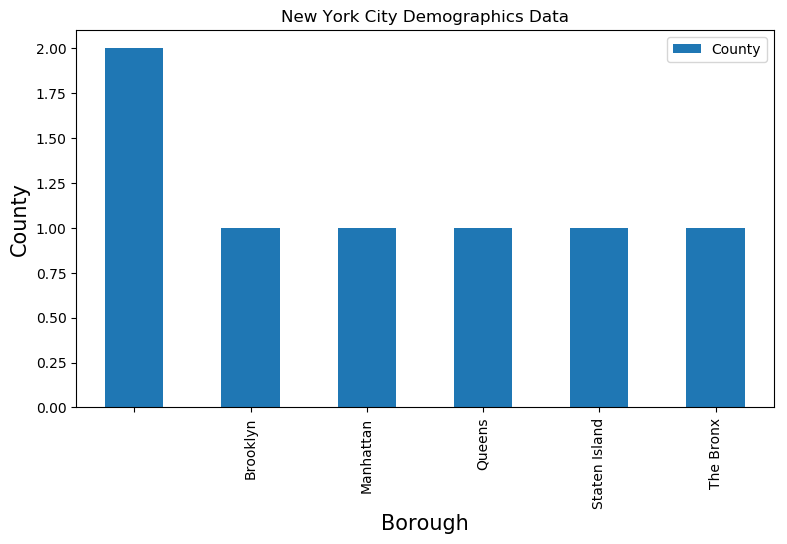

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('New York City Demographics Data')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('County', fontsize=15)
#giving a bar plot
df_NY_Population.groupby('Borough')['County'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

# Load New York Cuisine Data

In [30]:
col_names=['Borough','Neighborhood','Cuisine']

In [31]:
df = pd.DataFrame(columns =col_names)
df

,Borough,Neighborhood,Cuisine


In [50]:
from bs4 import BeautifulSoup
import requests

page = requests.get('https://en.wikipedia.org/wiki/Cuisine_of_New_York_City')

soup = BeautifulSoup(page.text, 'html.parser')

results = {}
articles = soup.find_all('div', class_ = "div-col columns column-width")
for article in articles:
    if article.find_previous_sibling('h2').find('span').get('id') == 'Enclaves_reflecting_national_cuisines':
    # Check if its the right element
        heading = soup.find('h3') 
        heading_data = heading.text
        category = article.find_previous_sibling('h3')
        title_key = category.find('span',{'class':'mw-headline'}).get_text()
        results[title_key] = []
        results[title_key] = article.text.split('\n')[1:len(article.text.split('\n'))-1]
        print(results)
    
        
        df = df.append({'Borough':title_key,
                        'Neighborhood':heading_data,
                        'Cuisine':results[title_key]}, ignore_index=True)
    
        
#print(results)
print("Titles are : ",title_key)

{'The Bronx': ['Bedford Park – Mexican, Puerto Rican, Dominican, Korean (on 204th St.)', 'Belmont – Italian, Albanian (also known as "Arthur Avenue," "Little Italy")', 'City Island – Italian, Seafood', 'Morris Park – Italian, Albanian', 'Norwood – Filipino (formerly Irish, less so today)', 'Riverdale – Jewish', 'South Bronx – Puerto Rican, Dominican', 'Wakefield – Jamaican, West Indian', 'Woodlawn – Irish']}
{'The Bronx': ['Bedford Park – Mexican, Puerto Rican, Dominican, Korean (on 204th St.)', 'Belmont – Italian, Albanian (also known as "Arthur Avenue," "Little Italy")', 'City Island – Italian, Seafood', 'Morris Park – Italian, Albanian', 'Norwood – Filipino (formerly Irish, less so today)', 'Riverdale – Jewish', 'South Bronx – Puerto Rican, Dominican', 'Wakefield – Jamaican, West Indian', 'Woodlawn – Irish'], 'Queens': ['Astoria – Greek, Italian, Eastern European, Brazilian, Egyptian and other Arabic', 'Bellerose – Indian and Pakistani', 'Flushing – Chinese and Korean', 'Forest Hill

In [46]:
df.head()

,Borough,Neighborhood,Cuisine
0,The Bronx,The Bronx[edit],"[Bedford Park – Mexican, Puerto Rican, Dominic..."
1,Queens,The Bronx[edit],"[Astoria – Greek, Italian, Eastern European, B..."
2,Brooklyn,The Bronx[edit],"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
3,Manhattan,The Bronx[edit],"[Chinatown – Chinese and Vietnamese, East Harl..."
4,The Bronx,The Bronx[edit],"[Bedford Park – Mexican, Puerto Rican, Dominic..."


In [51]:
df.shape

(52, 3)

In [52]:
print(df.Borough.unique())

['The Bronx' 'Queens' 'Brooklyn' 'Manhattan']


In [53]:
df['Borough'].value_counts().to_frame()

,Borough
Brooklyn,13
The Bronx,13
Manhattan,13
Queens,13


In [54]:
CUISINE_WC = df[['Cuisine']]
CUISINE_WC

,Cuisine
0,"[Bedford Park – Mexican, Puerto Rican, Dominic..."
1,"[Astoria – Greek, Italian, Eastern European, B..."
2,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
3,"[Chinatown – Chinese and Vietnamese, East Harl..."
4,"[Bedford Park – Mexican, Puerto Rican, Dominic..."
5,"[Astoria – Greek, Italian, Eastern European, B..."
6,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
7,"[Chinatown – Chinese and Vietnamese, East Harl..."
8,"[Bedford Park – Mexican, Puerto Rican, Dominic..."
9,"[Astoria – Greek, Italian, Eastern European, B..."


In [55]:
CUISINE_WC.to_csv('CUISINE_WC.txt', sep=',', index=False)

In [56]:
CUISINE_WC1 = open('CUISINE_WC.txt', 'r').read()

In [57]:

mpl.style.use('ggplot') # optional: for ggplot-like style

In [58]:
stopwords = set(STOPWORDS)


In [59]:
# instantiate a word cloud object
NYC_CUISINE_WC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
NYC_CUISINE_WC.generate(CUISINE_WC1)

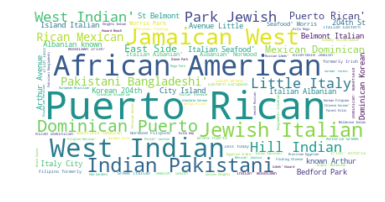

<Figure size 2160x3240 with 0 Axes>

In [60]:
# display the word cloud
plt.imshow(NYC_CUISINE_WC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

# From Above Plot, New  York Most Liked food can be ranked as
**1.American
  2.African
  3.West Indian
  4.Indian
  5.Pakistani
  6.Italian**

In [61]:
Queens_data = df[df['Borough'] == 'Queens'].reset_index(drop=True)
Queens_data.head()

,Borough,Neighborhood,Cuisine
0,Queens,The Bronx[edit],"[Astoria – Greek, Italian, Eastern European, B..."
1,Queens,The Bronx[edit],"[Astoria – Greek, Italian, Eastern European, B..."
2,Queens,The Bronx[edit],"[Astoria – Greek, Italian, Eastern European, B..."
3,Queens,The Bronx[edit],"[Astoria – Greek, Italian, Eastern European, B..."
4,Queens,The Bronx[edit],"[Astoria – Greek, Italian, Eastern European, B..."


In [62]:
Q_CUISINE_WC = Queens_data[['Cuisine']]
Q_CUISINE_WC

,Cuisine
0,"[Astoria – Greek, Italian, Eastern European, B..."
1,"[Astoria – Greek, Italian, Eastern European, B..."
2,"[Astoria – Greek, Italian, Eastern European, B..."
3,"[Astoria – Greek, Italian, Eastern European, B..."
4,"[Astoria – Greek, Italian, Eastern European, B..."
5,"[Astoria – Greek, Italian, Eastern European, B..."
6,"[Astoria – Greek, Italian, Eastern European, B..."
7,"[Astoria – Greek, Italian, Eastern European, B..."
8,"[Astoria – Greek, Italian, Eastern European, B..."
9,"[Astoria – Greek, Italian, Eastern European, B..."


In [63]:
Q_CUISINE_WC.to_csv('Q_CUISINE.txt', sep=',', index=False)

In [64]:
Q_CUISINE_WC = open('Q_CUISINE.txt', 'r').read()

In [65]:
stopwords = set(STOPWORDS)

In [66]:
# instantiate a word cloud object
Q_CUISINE_NYC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
Q_CUISINE_NYC.generate(Q_CUISINE_WC)

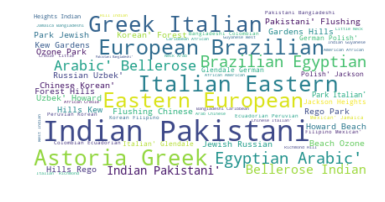

<Figure size 2160x3240 with 0 Axes>

In [67]:
# display the word cloud
plt.imshow(Q_CUISINE_NYC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

# From above plot we can say that in Queens Area Most Likely Food are from Indian and Pakistani Restaurants

In [68]:
Manhattan_data = df[df['Borough'] == 'Manhattan'].reset_index(drop=True)
Manhattan_data.head()

,Borough,Neighborhood,Cuisine
0,Manhattan,The Bronx[edit],"[Chinatown – Chinese and Vietnamese, East Harl..."
1,Manhattan,The Bronx[edit],"[Chinatown – Chinese and Vietnamese, East Harl..."
2,Manhattan,The Bronx[edit],"[Chinatown – Chinese and Vietnamese, East Harl..."
3,Manhattan,The Bronx[edit],"[Chinatown – Chinese and Vietnamese, East Harl..."
4,Manhattan,The Bronx[edit],"[Chinatown – Chinese and Vietnamese, East Harl..."


In [69]:
MN_CUISINE_WC = Manhattan_data[['Cuisine']]
MN_CUISINE_WC

,Cuisine
0,"[Chinatown – Chinese and Vietnamese, East Harl..."
1,"[Chinatown – Chinese and Vietnamese, East Harl..."
2,"[Chinatown – Chinese and Vietnamese, East Harl..."
3,"[Chinatown – Chinese and Vietnamese, East Harl..."
4,"[Chinatown – Chinese and Vietnamese, East Harl..."
5,"[Chinatown – Chinese and Vietnamese, East Harl..."
6,"[Chinatown – Chinese and Vietnamese, East Harl..."
7,"[Chinatown – Chinese and Vietnamese, East Harl..."
8,"[Chinatown – Chinese and Vietnamese, East Harl..."
9,"[Chinatown – Chinese and Vietnamese, East Harl..."


In [70]:
MN_CUISINE_WC.to_csv('MN_CUISINE.txt', sep=',', index=False)

In [71]:
MN_CUISINE_WC = open('MN_CUISINE.txt', 'r').read()

In [72]:
stopwords = set(STOPWORDS)

In [73]:
# instantiate a word cloud object
MN_CUISINE_NYC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
MN_CUISINE_NYC.generate(MN_CUISINE_WC)

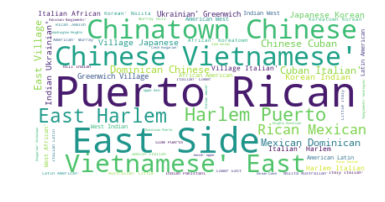

<Figure size 2160x3240 with 0 Axes>

In [74]:
# display the word cloud
plt.imshow(MN_CUISINE_NYC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

# From above plot we can say that in Manhatten Area Most Likely Food are from Chinese Restaurants

In [75]:
Brooklyn_data = df[df['Borough'] == 'Brooklyn'].reset_index(drop=True)
Brooklyn_data.head()

,Borough,Neighborhood,Cuisine
0,Brooklyn,The Bronx[edit],"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
1,Brooklyn,The Bronx[edit],"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
2,Brooklyn,The Bronx[edit],"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
3,Brooklyn,The Bronx[edit],"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
4,Brooklyn,The Bronx[edit],"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."


In [76]:
BR_CUISINE_WC = Brooklyn_data[['Cuisine']]
BR_CUISINE_WC

,Cuisine
0,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
1,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
2,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
3,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
4,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
5,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
6,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
7,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
8,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."
9,"[Bay Ridge – Irish, Italian, Greek, Turkish, L..."


In [77]:
BR_CUISINE_WC.to_csv('BR_CUISINE.txt', sep=',', index=False)

In [78]:
BR_CUISINE_WC = open('BR_CUISINE.txt', 'r').read()

In [79]:
stopwords = set(STOPWORDS)

In [80]:
# instantiate a word cloud object
BR_CUISINE_NYC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
BR_CUISINE_NYC.generate(BR_CUISINE_WC)

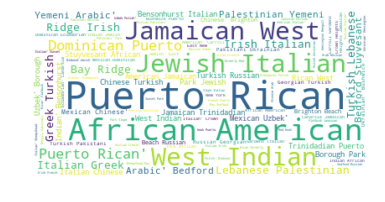

<Figure size 2160x3240 with 0 Axes>

In [81]:
# display the word cloud
plt.imshow(BR_CUISINE_NYC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

# From above plot we can say that in Brooklyn Area Most Likely Food are from American and African Restaurants

In [82]:
df_newyork['Borough'].value_counts().to_frame()

,Borough
Queens,81
Brooklyn,70
Staten Island,63
Bronx,52
Manhattan,40


In [83]:
df_man_brook = df_newyork.loc[(df_newyork['Borough'] == 'Brooklyn')|(df_newyork['Borough'] == 'Manhattan')]
df_man_brook = df_man_brook.reset_index(drop=True)
df_man_brook.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bensonhurst,40.611009,-73.995180
3,Brooklyn,Sunset Park,40.645103,-74.010316
4,Brooklyn,Greenpoint,40.730201,-73.954241


In [84]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [85]:
CLIENT_ID = 'PSHOLQXLVECKGZUS2SXIK5V41SPUO3TWGGJ20A34HQRDPFVN' # your Foursquare ID
CLIENT_SECRET = 'BKBUPX3RLBRS5MO5L1UVTZRL5HPDRVCIR51WFCYBLYMDKJEK' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

In [86]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=200, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
man_brook_venues = getNearbyVenues(names=df_man_brook['Neighborhood'],
                                  latitudes=df_man_brook['Latitude'],
                                  longitudes=df_man_brook['Longitude'],
                                  LIMIT=200)

print('The "man_brook_venues" dataframe has {} venues and {} unique venue types.'.format(
      len(man_brook_venues['Venue Category']),
      len(man_brook_venues['Venue Category'].unique())))

man_brook_venues.to_csv('man_brook_venues.csv', sep=',', encoding='UTF8')
man_brook_venues.head()

Marble Hill
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [88]:
colnames = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
man_brook_venues = pd.read_csv('man_brook_venues.csv', skiprows=1, names=colnames)
man_brook_venues.columns = man_brook_venues.columns.str.replace(' ', '')
man_brook_venues.head()

,Neighborhood,NeighborhoodLatitude,NeighborhoodLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [89]:
man_brook_venues.groupby('VenueCategory')['Venue'].count().sort_values(ascending=False)

VenueCategory
Pizza Place                                 379
Coffee Shop                                 329
Italian Restaurant                          250
Bakery                                      216
Bar                                         207
Café                                        206
Park                                        191
American Restaurant                         179
Grocery Store                               174
Sandwich Place                              152
Ice Cream Shop                              150
Mexican Restaurant                          149
Caribbean Restaurant                        147
Gym                                         140
Gym / Fitness Center                        140
Deli / Bodega                               140
Chinese Restaurant                          135
Cocktail Bar                                133
Wine Shop                                   131
Sushi Restaurant                            125
Donut Shop                

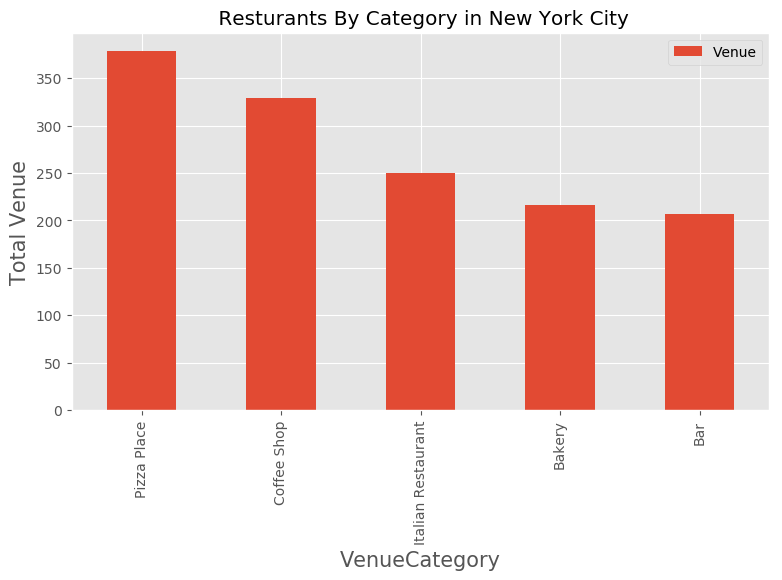

In [91]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title(' Resturants By Category in New York City')
#On x-axis
plt.xlabel('VenueCategory', fontsize = 15)
#On y-axis
plt.ylabel('Total Venue', fontsize=15)
#giving a bar plot
man_brook_venues.groupby('VenueCategory')['Venue'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [92]:
# one hot encoding
man_brook_onehot = pd.get_dummies(man_brook_venues[['VenueCategory']], prefix="", prefix_sep="")

#column lists before adding neighborhood
column_names = ['Neighborhood'] + list(man_brook_onehot.columns)

# add neighborhood column back to dataframe
man_brook_onehot['Neighborhood'] = man_brook_venues['Neighborhood'] 

# move neighborhood column to the first column
man_brook_onehot = man_brook_onehot[column_names]

man_brook_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pe

In [93]:
restaurant_names = []
rest_word = 'Restaurant'
for restlist in man_brook_onehot.columns :
    if rest_word in restlist:
        restaurant_names.append(restlist)

In [94]:
restaurant_names

['African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Brazilian Restaurant',
 'Burmese Restaurant',
 'Cajun / Creole Restaurant',
 'Cambodian Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Colombian Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Greek Restaurant',
 'Halal Restaurant',
 'Hawaiian Restaurant',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Curry Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Kebab Restaurant',
 'Korean Restaurant',
 'Kosher Restaurant

In [95]:
col_name = []
col_name = ['Neighborhood'] + restaurant_names
man_brook_restaurant = man_brook_onehot[col_name]
man_brook_restaurant = man_brook_restaurant.iloc[:,1::]

In [104]:
man_brook_restaurant_grouped = man_brook_restaurant.groupby('Neighborhood').sum().reset_index()

In [105]:
man_brook_restaurant_grouped['Total'] = man_brook_restaurant_grouped .sum(axis=1)

In [106]:
df_man_brook_restaurant = man_brook_restaurant_grouped.drop('Neighborhood', 1)


# Use K means Clustering to Analyze Data

In [108]:
# set number of clusters
no_of_clusters = 3


# run k-means clustering
kmeans_model = KMeans(n_clusters=no_of_clusters, random_state=0).fit(df_man_brook_restaurant)

# check cluster labels generated for each row in the dataframe
kmeans_model.labels_

array([2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0,
       2, 0, 1, 0, 1, 2, 0, 1, 0, 1, 2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0,
       0, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2,
       1, 1, 0, 2, 1, 0, 1, 2, 2, 1, 2, 0, 1, 0, 1, 0, 2, 2, 2, 1, 0, 0,
       0, 1, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 1, 2],
      dtype=int32)

In [109]:
man_brook_cluster = pd.DataFrame(kmeans_model.cluster_centers_)
man_brook_cluster.columns = df_man_brook_restaurant.columns
man_brook_cluster.index = ['Cluster0','Cluster1','Cluster2']
man_brook_cluster['Total Sum'] = man_brook_cluster.sum(axis = 1)
man_brook_cluster

,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Total,Total Sum
Cluster0,0.021739,1.717391,6.521739e-02,6.521739e-02,0.413043,1.086957e-01,1.086957e-01,2.173913e-02,2.173913e-02,6.521739e-02,2.173913e-02,2.775558e-17,1.173913,8.695652e-02,0.934783,2.173913e-02,8.695652e-02,0.260870,2.173913e-02,8.695652e-02,1.739130e-01,2.173913e-02,2.173913e-02,8.695652e-02,0.282609,0.521739,6.521739e-02,1.152174,1.304348e-01,3.478261e-01,8.695652e-02,2.081668e-17,0.000000,0.347826,4.347826e-02,2.782609,8.695652e-02,1.173913,0.000000e+00,-3.469447e-18,1.086957e-01,4.347826e-02,0.347826,4.347826e-02,2.173913e-02,0.521739,1.043478,0.500000,2.173913e-02,4.347826e-02,-6.938894e-18,0.500000,-1.734723e-18,2.173913e-02,2.173913e-02,0.130435,6.521739e-02,1.956522e-01,0.673913,0.195652,2.173913e-02,1.000000,-1.734723e-18,6.521739e-02,0.000000e+00,0.065217,0.217391,0.239130,1.326087,2.173913e-02,2.173913e-02,2.173913e-02,2.173913e-01,0.717391,0.000000e+00,0.217391,2.173913e-02,-1.734723e-18,0.478261,-3.469447e-18,3.260870e-01,22.108696,44.217391
Cluster1,0.034483,0.896552,-1.387779e-17,-1.387779e-17,0.068966,-1.387779e-17,-2.775558e-17,-1.734723e-18,-1.734723e-18,2.081668e-17,1.040834e-17,-2.775558e-17,1.310345,2.081668e-17,0.965517,-1.734723e-18,2.081668e-17,0.068966,-3.469447e-18,-1.387779e-17,-4.163336e-17,-6.938894e-18,-3.469447e-18,4.163336e-17,0.034483,1.310345,-1.387779e-17,0.034483,-1.387779e-17,2.775558e-16,-6.938894e-18,2.081668e-17,0.034483,0.103448,2.081668e-17,0.586207,-2.775558e-17,0.275862,1.040834e-17,3.448276e-02,-1.110223e-16,1.040834e-17,0.482759,2.081668e-17,-6.938894e-18,0.137931,0.551724,0.137931,-1.734723e-18,-3.469447e-18,-6.938894e-18,0.103448,-1.734723e-18,-1.734723e-18,1.040834e-17,0.068966,1.040834e-17,-2.775558e-17,0.586207,0.103448,-3.469447e-18,0.517241,-1.734723e-18,2.081668e-17,1.040834e-17,0.103448,0.137931,0.275862,0.275862,-1.734723e-18,2.081668e-17,-3.469447e-18,5.551115e-17,0.034483,1.040834e-17,0.034483,-6.938894e-18,-1.734723e-18,0.034483,-3.469447e-18,-5.551115e-17,9.344828,18.689655
Cluster2,0.142857,2.114286,1.428571e-01,1.428571e-01,0.628571,1.142857e-01,5.714286e-02,-1.734723e-18,-1.734723e-18,5.714286e-02,5.714286e-02,2.000000e-01,1.571429,5.714286e-02,1.828571,-1.734723e-18,5.714286e-02,0.257143,2.857143e-02,1.142857e-01,8.571429e-02,8.571429e-02,2.857143e-02,2.285714e-01,0.114286,0.314286,1.428571e-01,0.914286,8.571429e-02,5.142857e-

**Cluster0 : The Total and Total Sum of cluster0 has smallest value. It shows that the cluster0 has few restaurants in NEWYork.**


**Cluster1 : The Total and Total Sum of cluster1 has Middle value. It shows that the markets are Cluster 1 is growing restaurants business  in NEWYork.**


**Cluster2 : The Total and Total Sum of cluster1 has highest value. It shows that the Cluster2 has high number of restaurants in NEWYork**
